In [ ]:
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage.io, skimage.color, skimage.transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
import cv2  

In [69]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
path = r"/home/azure/datasets"
files = np.array(pd.read_csv(r"/home/azure/datasets/files.csv"))

selected_indices = np.random.choice(len(files), int(0.56 * len(files)), replace=False)
selected_files = files[selected_indices, 0]

files_train, files_valid, cls_train, cls_valid = train_test_split(
    selected_files, files[selected_indices, 1], test_size=0.2, random_state=40
)

print(files_train.shape, files_valid.shape)
cls_train = to_categorical(cls_train, 205, dtype='int')
cls_valid = to_categorical(cls_valid, 205, dtype='int')


(106684,) (26672,)


In [71]:
def batch_generator(for_train, batch_size):
    while True:
        if for_train is True:
            idx = np.random.randint(0, files_train.shape[0], batch_size)
        else:
            idx = np.random.randint(0, files_valid.shape[0], batch_size)

        gray = np.zeros((batch_size, 256, 256, 1))
        colo = np.zeros((batch_size, 256, 256, 2))
        cls = np.zeros((batch_size, 205))

        for i in range(batch_size):
            if for_train is True:
                temp = cv2.imread(os.path.join(path, files_train[idx[i]]))
                cls[i,:] = cls_train[idx[i]]
            else:
                temp = cv2.imread(os.path.join(path, files_valid[idx[i]]))
                cls[i,:] = cls_valid[idx[i]]

            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2LAB)
            temp = cv2.resize(temp, (256, 256))
            gray[i,:,:,0] = temp[:,:,0]
            colo[i] = temp[:,:,1:]

        gray = gray/100
        colo = (colo+128)/255
        yield gray, [cls, colo]


In [72]:
gray_image = Input(shape=(256, 256, 1))

In [73]:
conv = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(gray_image))
low_glo = BatchNormalization()(conv(gray_image))

conv = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))



In [74]:
low_mid = Dropout(0.5)(low_mid)

In [75]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [76]:
glo = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='tanh')(low_glo)
glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(glo)
glo = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='tanh')(glo)
glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(glo)
glo = Flatten()(glo)
glo = Dense(1024, activation='tanh')(glo)
glo_512 = Dense(512, activation='tanh')(glo)
glo = Dense(256, activation='tanh')(glo_512)
print(glo)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_20/Tanh:0', description="created by layer 'dense_20'")


In [77]:
cls = Dense(256, activation='tanh')(glo_512)
cls = Dense(205, activation='softmax')(cls)

In [78]:
mid = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
mid = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='tanh')(mid)
print(mid)  

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='conv2d_80/Tanh:0', description="created by layer 'conv2d_80'")


In [79]:
print(mid)
print(glo)

fused = Reshape((1, 1, 256))(glo)
fused = Lambda(lambda x: tf.tile(x, (1, 32, 32, 1)))(fused)
fused = concatenate([mid, fused], 3)
fused = Dense(256, activation='tanh')(fused)
print(fused)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='conv2d_80/Tanh:0', description="created by layer 'conv2d_80'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_20/Tanh:0', description="created by layer 'dense_20'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='dense_23/Tanh:0', description="created by layer 'dense_23'")


In [80]:
colo = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='tanh')(fused)
colo = UpSampling2D((2, 2))(colo)
colo = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
colo = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
colo = UpSampling2D((2, 2))(colo)
colo = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
output = Conv2D(2, (3, 3), strides=(1, 1), padding='same', activation='sigmoid')(colo)
output = UpSampling2D((2, 2))(output)
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None), name='up_sampling2d_11/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_11'")


In [81]:
conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
low_mid = BatchNormalization()(conv)
low_mid = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
low_mid = BatchNormalization()(low_mid)

conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_glo)
low_glo = BatchNormalization()(conv)
low_glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_glo)
low_glo = BatchNormalization()(low_glo)

In [83]:
model = Model(inputs=gray_image, outputs=[cls, output])
model.compile(optimizer = "adam", loss = ["categorical_crossentropy", "mse"])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 128, 128, 64  640         ['input_5[0][0]',                
                                )                                 'input_5[0][0]']                
                                                                                                  
 batch_normalization_61 (BatchN  (None, 128, 128, 64  256        ['conv2d_69[1][0]']              
 ormalization)                  )                                                           

                                                                                                  
 dense_22 (Dense)               (None, 205)          52685       ['dense_21[0][0]']               
                                                                                                  
 up_sampling2d_11 (UpSampling2D  (None, 256, 256, 2)  0          ['conv2d_85[0][0]']              
 )                                                                                                
                                                                                                  
Total params: 50,228,911
Trainable params: 50,223,535
Non-trainable params: 5,376
__________________________________________________________________________________________________
None


In [84]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss=["categorical_crossentropy", "mse"])

c:\Users\owais akmad khan\.conda\envs\owais\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [91]:
batch_size = 4
train_gen = batch_generator(True, batch_size = batch_size)
valid_gen = batch_generator(False, batch_size = batch_size)

In [92]:
callbacks = [
    ModelCheckpoint('cv2model.h5', save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [93]:
history = model.fit(
    x=train_gen,
    epochs=6,
    steps_per_epoch=files_train.shape[0] // (batch_size // 2),
    validation_data=valid_gen,
    validation_steps=files_valid.shape[0] // (batch_size // 2),
    callbacks=callbacks
)

Epoch 1/6
53342/53342 [==============================] - 10624s 199ms/step - loss: 5.1004 - dense_22_loss: 5.0961 - up_sampling2d_11_loss: 0.0043 - val_loss: 4.9218 - val_dense_22_loss: 4.9174 - val_up_sampling2d_11_loss: 0.0043
Epoch 2/6
53342/53342 [==============================] - 10608s 199ms/step - loss: 4.5996 - dense_22_loss: 4.5958 - up_sampling2d_11_loss: 0.0038 - val_loss: 4.4623 - val_dense_22_loss: 4.4587 - val_up_sampling2d_11_loss: 0.0036
Epoch 3/6
53342/53342 [==============================] - 13576s 255ms/step - loss: 4.3591 - dense_22_loss: 4.3555 - up_sampling2d_11_loss: 0.0036 - val_loss: 4.3137 - val_dense_22_loss: 4.3101 - val_up_sampling2d_11_loss: 0.0036
Epoch 4/6
53342/53342 [==============================] - 10685s 200ms/step - loss: 4.2168 - dense_22_loss: 4.2133 - up_sampling2d_11_loss: 0.0036 - val_loss: 4.2312 - val_dense_22_loss: 4.2276 - val_up_sampling2d_11_loss: 0.0036
Epoch 5/6
53342/53342 [==============================] - 10715s 201ms/step - loss: 4

In [ ]:
def colorize(orig, resized):
    predicted = model.predict(resized)[1]
    resized = np.concatenate((resized, predicted), axis=3)

    for pos in range(resized.shape[0]):
        resized[pos, :, :, 0] = resized[pos, :, :, 0] * 100
        resized[pos, :, :, 1:] = resized[pos, :, :, 1:] * 255 - 128

        lab_image = resized[pos].astype(np.uint8)
        rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

        plt.imshow(orig[pos])
        plt.show()

        plt.imshow(rgb_image)
        plt.show()



1/1 [==============================] - 2s 2s/step


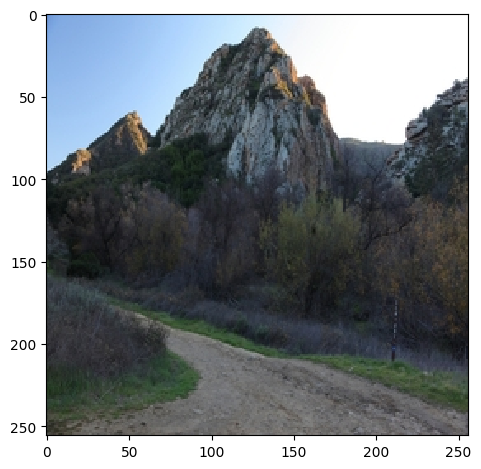

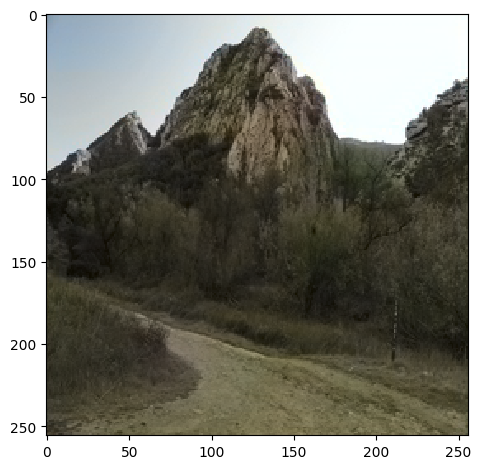

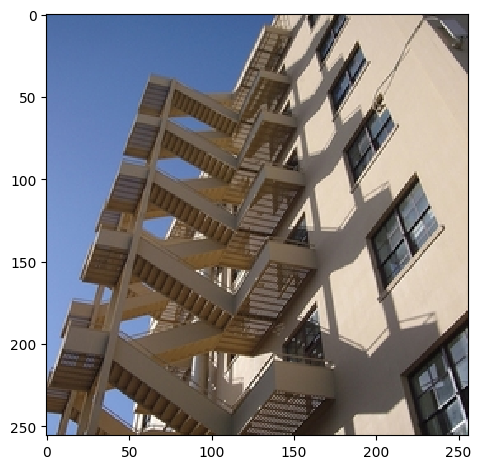

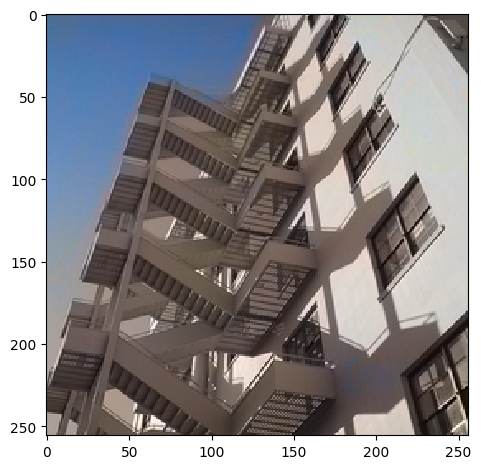

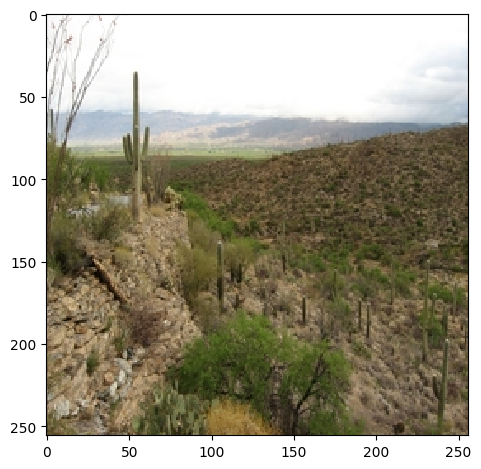

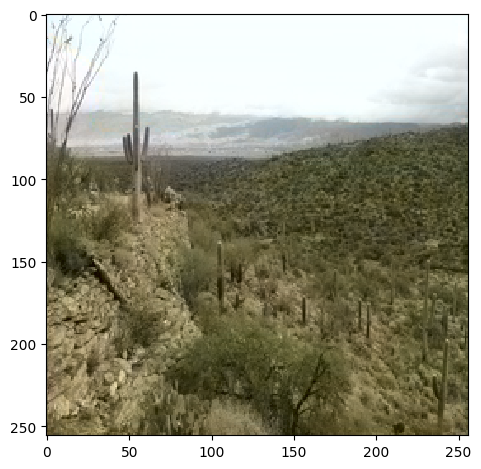

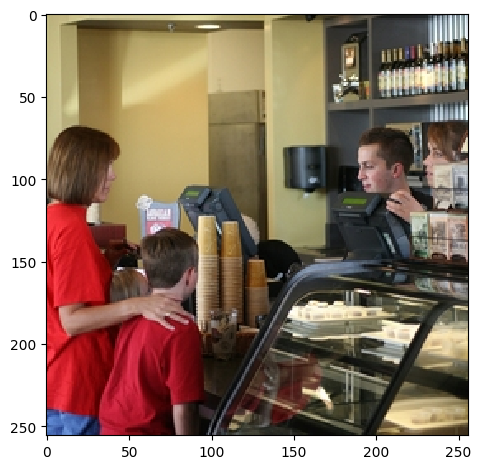

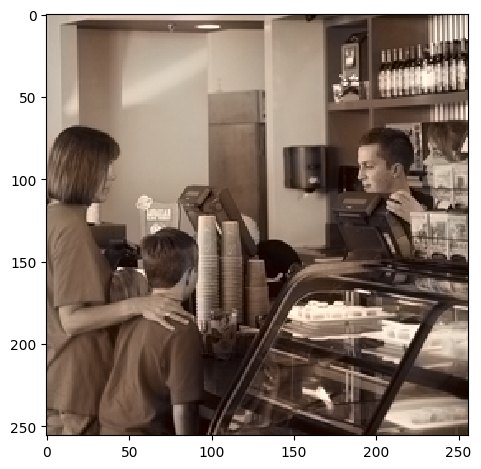

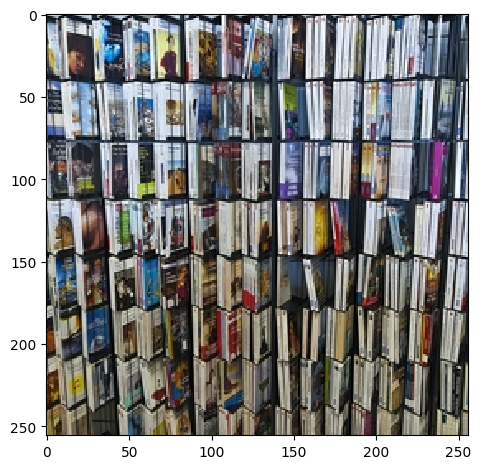

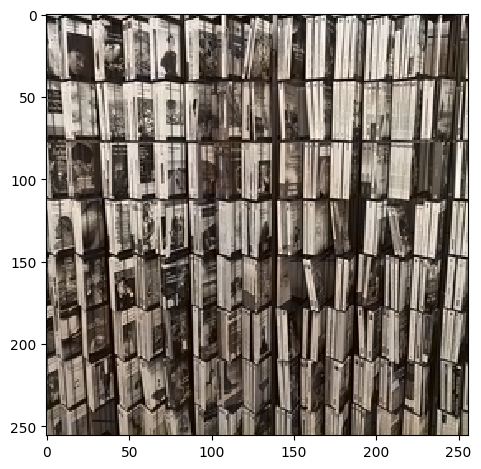

In [ ]:

files = files_train
orig = []
num = 5
resized = np.zeros((num, 256, 256, 1))
for pos in range(num):
    orig.append(cv2.imread(path + files[pos]))
    temp = cv2.resize(orig[pos], (256, 256))
    
    if temp.shape[2] == 3:
        temp = cv2.cvtColor(temp, cv2.COLOR_RGB2LAB)[:, :, 0]
        temp = temp / 100
    
    if temp.shape[2] == 1:
        resized[pos] = temp
    else:
        resized[pos, :, :, 0] = temp

colorize(orig, resized)